In [1]:
import numpy as np
from tqdm import tqdm, trange
import os
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, LambdaLR
import torch.nn.functional as TF
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset,ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.transforms as transforms
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import confusion_matrix

np.random.seed(0)
torch.manual_seed(0)
NUM_WORKERS = os.cpu_count()

In [2]:
import numpy as np
import torch
import torchvision
from torch.nn import CrossEntropyLoss
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

Using device: cuda (Quadro GP100)


In [4]:
class Denoise(object):
    def __init__(self, strength=10):
        self.strength = strength

    def __call__(self, img):
        # Convert PIL image to Tensor
        img = F.to_tensor(img)
        
        # Add Gaussian noise to each channel independently
        noisy_img = img.clone()
        for c in range(noisy_img.shape[0]):  # Iterate over channels
            noisy_img[c] += torch.randn_like(noisy_img[c]) * self.strength / 255.0
            noisy_img[c] = torch.clamp(noisy_img[c], 0, 1)  # Ensure pixel values are in [0, 1] range
        
        return F.to_pil_image(noisy_img)



# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    Denoise(strength=10),  # Add denoising transformation
    transforms.ToTensor(),  # Convert back to Tensor after denoising
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



# Loading data
train_set = '/home/medikondamanisumanth/project/Project/Damage Type.v1-damage-type-v1.tensorflow/train_2'
test_set = '/home/medikondamanisumanth/project/Project/Damage Type.v1-damage-type-v1.tensorflow/test_1'
valid_set = '/home/medikondamanisumanth/project/Project/Damage Type.v1-damage-type-v1.tensorflow/valid_1'

# Create datasets
train_dataset_original = ImageFolder(train_set, transform=transform)
test_dataset_original = ImageFolder(test_set, transform=transform)
valid_dataset = ImageFolder(valid_set, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset_original, shuffle=True, batch_size=64, num_workers=2)
test_loader = DataLoader(test_dataset_original, shuffle=False, batch_size=64, num_workers=2)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=64, num_workers=2)


In [19]:
import timm

model_name = 'deit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=4)
model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f'Epoch: {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')

Epoch: 1/5, Test Accuracy: 0.4381
Epoch: 2/5, Test Accuracy: 0.4300
Epoch: 3/5, Test Accuracy: 0.4280
Epoch: 4/5, Test Accuracy: 0.5071
Epoch: 5/5, Test Accuracy: 0.4787


In [21]:
torch.save(model.state_dict(), 'diet_model_pre.pth')
model.load_state_dict(torch.load('diet_model_pre.pth'))

<All keys matched successfully>

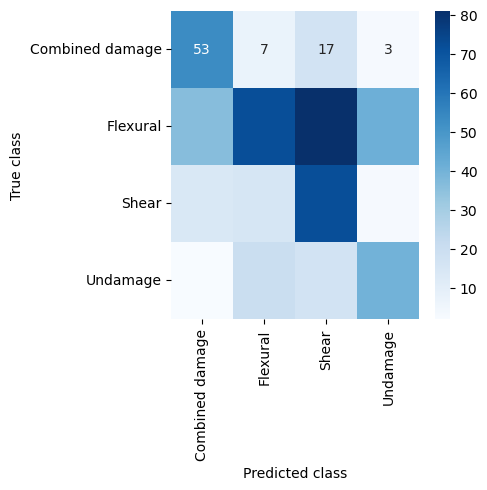

In [23]:
            model.eval()
            train_predicted_probabilities = []
            train_targets = []
            with torch.no_grad():
                correct, total = 0, 0
                train_loss = 0.0
                for batch_idx, (data, target) in enumerate(test_loader):
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
            
                    train_loss += loss.detach().cpu().item()/len(train_loader)
                    correct += torch.sum(torch.argmax(output, dim=1) == target).detach().cpu().item()
                    total += len(data)
                    predicted_probabilities = torch.nn.functional.softmax(output, dim=1)
            
                    for i in range(len(target)):
                        train_predicted_probabilities.append(predicted_probabilities[i].detach().cpu().numpy())
                        train_targets.append(target[i].item())
            train_predicted_probabilities = np.array(train_predicted_probabilities)
            
            # Compute the predicted classes based on the probability values
            train_predictions = np.argmax(train_predicted_probabilities, axis=1)
            
            # Compute the confusion matrix
            confusion_mtx = confusion_matrix(train_targets, train_predictions)
            predicted_class_names = ['Combined damage', 'Flexural', 'Shear', 'Undamage']
            # Plot confusion matrix as heatmap
            plt.figure(figsize=(4, 4))
            sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_class_names,
                         yticklabels=predicted_class_names)
            plt.xlabel('Predicted class')
            plt.ylabel('True class')
            plt.show()

Test accuracy: 48.48%
Test loss: 1.12


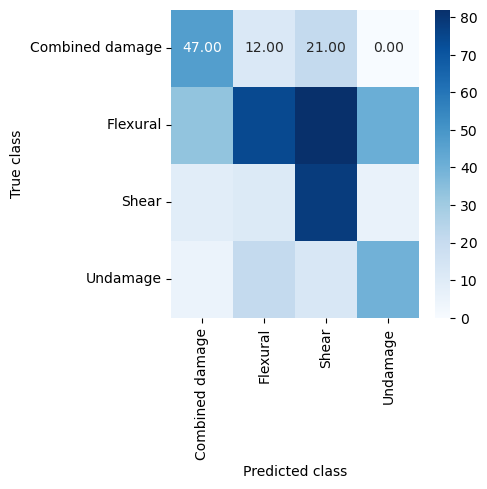

In [22]:

            model.eval()
            test_predicted_probabilities = []
            test_targets = []
            with torch.no_grad():
                correct, total = 0, 0
                test_loss = 0.0
                for batch_idx, (data, target) in enumerate(test_loader):
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
            
                    test_loss += loss.detach().cpu().item()/len(test_loader)
                    correct += torch.sum(torch.argmax(output, dim=1) == target).detach().cpu().item()
                    total += len(data)
                    predicted_probabilities = torch.nn.functional.softmax(output, dim=1)
            
                    for i in range(len(target)):
                        test_predicted_probabilities.append(predicted_probabilities[i].detach().cpu().numpy())
                        test_targets.append(target[i].item())
            
                test_accuracy = 100. * correct / total
                print(f"Test accuracy: {test_accuracy:.2f}%")
                print(f"Test loss: {test_loss:.2f}")
            
            # Convert list to numpy array
            test_predicted_probabilities = np.array(test_predicted_probabilities)
            
            # Compute the predicted classes based on the probability values
            test_predictions = np.argmax(test_predicted_probabilities, axis=1)
            
            # Compute the confusion matrix
            confusion_mtx = confusion_matrix(test_targets, test_predictions)
            predicted_class_names = ['Combined damage', 'Flexural', 'Shear', 'Undamage']
            # Plot confusion matrix as heatmap
            plt.figure(figsize=(4, 4))
            sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=predicted_class_names,
                         yticklabels=predicted_class_names)
            plt.xlabel('Predicted class')
            plt.ylabel('True class')
            plt.show()
            
            # Generate text based on the predicted class
            predicted_class_names = ['Combined damage', 'Flexural', 'Shear', 'Undamage']
            #for i in range(len(test_predictions)):
                #class_index = test_predictions[i]
                #generate_text_from_class(class_index, predicted_class_names)

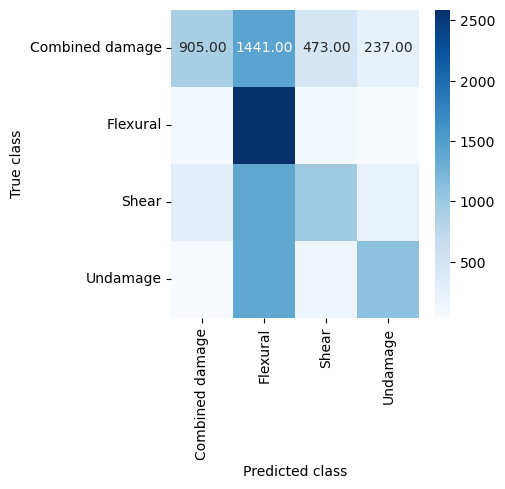

In [9]:
model.eval()
train_predicted_probabilities = []
train_targets = []
with torch.no_grad():
    correct, total = 0, 0
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        train_loss += loss.detach().cpu().item()/len(train_loader)
        predicted_probabilities = torch.nn.functional.softmax(output, dim=1)
        for i in range(len(target)):
            train_predicted_probabilities.append(predicted_probabilities[i].detach().cpu().numpy())
            train_targets.append(target[i].item())

train_predicted_probabilities = np.array(train_predicted_probabilities)

# Compute the confusion matrix based on the probability values
confusion_mtx = confusion_matrix(train_targets, np.argmax(train_predicted_probabilities, axis=1))
predicted_class_names = ['Combined damage', 'Flexural', 'Shear', 'Undamage']

# Plot confusion matrix as heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=predicted_class_names,
             yticklabels=predicted_class_names)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()